# Предсказание "рейтинга опасности" районов Барселоны

Датасет с Kaggle https://www.kaggle.com/xvivancos/barcelona-data-sets#accidents_2017.csv

Список инцидентов зафиксированных местной полицией. Удалим ID, название улицы, окрестности и района, так как эти данные заменяться координатами места.

In [18]:
import pandas as pd
data = pd.read_csv('accidents.csv')
data = data.drop(columns=['Street', 'Neighborhood Name', 'District Name', 'Id'])
data.head()

,Weekday,Month,Day,Hour,Part of the day,Mild injuries,Serious injuries,Victims,Vehicles involved,Longitude,Latitude
0,Friday,October,13,8,Morning,2,0,2,2,2.125624,41.340045
1,Friday,September,1,13,Morning,2,0,2,2,2.120452,41.339426
2,Friday,December,8,21,Afternoon,5,0,5,2,2.167356,41.360885
3,Friday,July,21,2,Night,1,0,1,2,2.124529,41.337668
4,Thursday,May,25,14,Afternoon,1,0,1,3,2.185272,41.416365


## Подготовка данных

Используем данные о кол-ве пострадавших для создания нового показателя - рейтинга опасности. Путём мучительных экспериментов выведена формула: логарифм от произведения кол-ва транспортных средств и суммы кол-ва пострадавших средне, квадрата кол-ва пострадавших серьёзно и экспоненты от числа погибших. Также уравнены по 1% наименьших и наибольших значений.

In [19]:
from scipy.stats import mstats
from numpy import exp, log

def a(x):
    return log((x['Mild injuries'] + x['Serious injuries']**2 + exp(x['Victims']))*x['Vehicles involved'])

data['Rate'] = data[['Mild injuries','Serious injuries', 'Victims', 'Vehicles involved']].apply(a,axis=1)
data['Rate'] = pd.Series(mstats.winsorize(data['Rate'], limits=[0.01,0.01]))
df = data.drop(columns=['Mild injuries','Serious injuries', 'Victims', 'Vehicles involved']).dropna()
df.head()

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


,Weekday,Month,Day,Hour,Part of the day,Longitude,Latitude,Rate
0,Friday,October,13,8,Morning,2.125624,41.340045,2.932692
1,Friday,September,1,13,Morning,2.120452,41.339426,2.932692
2,Friday,December,8,21,Afternoon,2.167356,41.360885,4.763850
3,Friday,July,21,2,Night,2.124529,41.337668,2.006409
4,Thursday,May,25,14,Afternoon,2.185272,41.416365,2.411874


### Построим графики зависимости целевой переменной и признаков

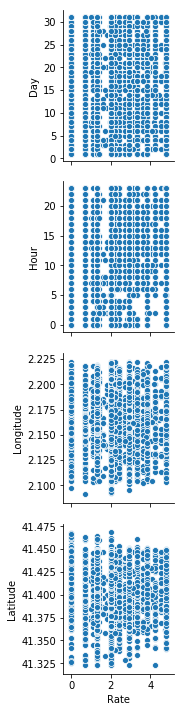

In [20]:
import seaborn as sns
%matplotlib inline

pp = sns.pairplot(data=data,
                  x_vars=['Rate'],
                  y_vars=['Day','Hour', 'Longitude', 'Latitude'])

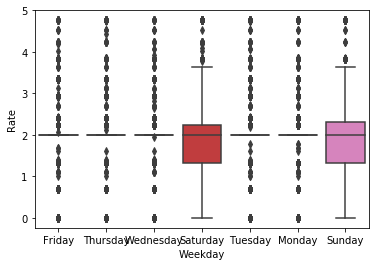

In [21]:
pp = sns.boxplot(data=data,
                  y='Rate',
                  x='Weekday')

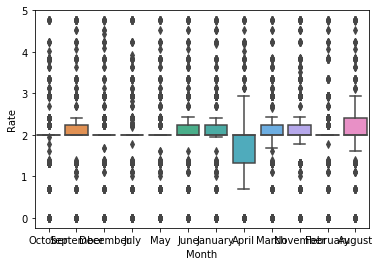

In [22]:
pp = sns.boxplot(data=data,
                  y='Rate',
                  x='Month')

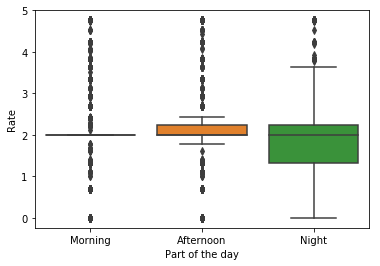

In [23]:
pp = sns.boxplot(data=data,
                  y='Rate',
                  x='Part of the day')

Заметно, что значения на день и час распределены довольно равномерно, но день недели, месяц и часть дня имеют разные графики в зависимости от значения признака. Удалим эти значения, а также некоторые значения категориальных признаков, имеющих схожие графики.

In [24]:
df = df.drop(columns=['Day', 'Hour'])
df = pd.get_dummies(df, columns=['Weekday', 'Month', 'Part of the day'])
df = df.drop(columns=['Weekday_Friday','Weekday_Monday', 'Weekday_Thursday', 
                      'Weekday_Tuesday','Weekday_Wednesday', 'Month_July','Month_May','Month_October',
                      'Month_December', 'Month_February'])
df.head()

,Longitude,Latitude,Rate,Weekday_Saturday,Weekday_Sunday,Month_April,Month_August,Month_January,Month_June,Month_March,Month_November,Month_September,Part of the day_Afternoon,Part of the day_Morning,Part of the day_Night
0,2.125624,41.340045,2.932692,0,0,0,0,0,0,0,0,0,0,1,0
1,2.120452,41.339426,2.932692,0,0,0,0,0,0,0,0,1,0,1,0
2,2.167356,41.360885,4.763850,0,0,0,0,0,0,0,0,0,1,0,0
3,2.124529,41.337668,2.006409,0,0,0,0,0,0,0,0,0,0,0,1
4,2.185272,41.416365,2.411874,0,0,0,0,0,0,0,0,0,1,0,0


Построим несколько моделей. Выберем из них наилучшую.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y = df['Rate']
X = df.drop(columns='Rate')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3)

def print_err(est, text):
    print(text)
    print('MSE {0}'.format(mean_squared_error(y_test, est.predict(X_test))))
    print('MAE {0}'.format(mean_absolute_error(y_test, est.predict(X_test))))
    print('R2 {0}\n'.format(r2_score(y_test, est.predict(X_test))))

#поиск наилучших параметров для KernelRidge
param_grid = {"alpha": [1, 0.1, 0.01, 0.001]}
grid = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)

#поиск наилучших параметров для LinearSVR

from sklearn.svm import LinearSVR

LSVR_p = {"tol": [1, 0.1, 0.00001, 0.000001],
             'C': [1,10,50]}
grid_LSVR = GridSearchCV(LinearSVR(), cv=5, param_grid=LSVR_p, n_jobs=-1)
grid_LSVR.fit(X_train, y_train)

#поиск наилучших параметров для SVR

from sklearn.svm import SVR

SVR_p = {"degree": [2,3,4],
         'C': [1,5,10],
         "tol": [1, 0.1, 0.001, 0.000001]}
grid_SVR = GridSearchCV(SVR(gamma='scale'), cv=5, param_grid=SVR_p, n_jobs=-1)
grid_SVR.fit(X_train, y_train)

print('KernelRidge {0}'.format(grid.best_params_))
print('LinearSVR {0}'.format(grid_LSVR.best_params_))
print('SVR {0}'.format(grid_SVR.best_params_))

D:\Мои файлы\Программы\python\data_analyse_labs\venv\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


KernelRidge {'alpha': 1}
LinearSVR {'C': 10, 'tol': 1}
SVR {'C': 5, 'degree': 2, 'tol': 0.1}


In [26]:
print_err(grid, 'KernelRidge')
print_err(grid_LSVR, 'LinearSVR')
print_err(grid_SVR, 'SVR')

KernelRidge
MSE 0.6608788477786277
MAE 0.5011239583884978
R2 0.00573363694980189

LinearSVR
MSE 0.6630054980749702
MAE 0.49151793319977405
R2 0.0025341748052176705

SVR
MSE 0.6645756926940186
MAE 0.5260257015480292
R2 0.00017187845028099336



In [27]:
df.agg(['max', 'min', 'mean'])

,Longitude,Latitude,Rate,Weekday_Saturday,Weekday_Sunday,Month_April,Month_August,Month_January,Month_June,Month_March,Month_November,Month_September,Part of the day_Afternoon,Part of the day_Morning,Part of the day_Night
max,2.222572,41.468244,4.763850,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,2.091855,41.323094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,2.162832,41.399346,2.024196,0.111713,0.086565,0.081729,0.063062,0.081633,0.087823,0.090434,0.095851,0.074379,0.491537,0.393365,0.115098


## Отрисовка карты

Подготовим данные для отображения. Так как данные меняются в зависимости от времени, зафиксируем день, месяц и время суток.

In [31]:
map_df = df[['Longitude', 'Latitude']].drop_duplicates()
map_df = map_df.append(df[(df['Weekday_Sunday']==1) & (df['Month_June']==1) & (df['Part of the day_Night']==1)].head(1)
               .drop(columns='Rate'), sort=False).fillna(0)
map_df['Weekday_Sunday'] = 1
map_df['Month_June'] = 1
map_df['Part of the day_Night'] = 1
map_df.head()

,Longitude,Latitude,Weekday_Saturday,Weekday_Sunday,Month_April,Month_August,Month_January,Month_June,Month_March,Month_November,Month_September,Part of the day_Afternoon,Part of the day_Morning,Part of the day_Night
0,2.125624,41.340045,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1
1,2.120452,41.339426,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1
2,2.167356,41.360885,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1
3,2.124529,41.337668,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1
4,2.185272,41.416365,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1


Составим прогноз для каждой точки карты

In [32]:
map_df['Rate'] = pd.Series(grid.predict(map_df))
map_df = map_df.fillna(0)
map_df.head()

,Longitude,Latitude,Weekday_Saturday,Weekday_Sunday,Month_April,Month_August,Month_January,Month_June,Month_March,Month_November,Month_September,Part of the day_Afternoon,Part of the day_Morning,Part of the day_Night,Rate
0,2.125624,41.340045,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,1.935724
1,2.120452,41.339426,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,1.935379
2,2.167356,41.360885,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,1.939229
3,2.124529,41.337668,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,1.935549
4,2.185272,41.416365,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,1.942842


In [33]:
import folium
from folium.plugins import HeatMap
import numpy as np

accidence_map = folium.Map(location=[41.399346,2.162832], zoom_start=12)
data = [[x[0], x[1], x[2]] for x in np.array(map_df[['Latitude', 'Longitude', 'Rate']])]
HeatMap(data, radius = 20).add_to(accidence_map)
accidence_map